In [4]:
# By Maryam Rezayati
# Ref  for lstm: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

# this model should be trained in the same conda environment which robot will be runned
# conda activate frankapyenv

import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import ConfusionMatrix
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score,  classification_report
from load_dataset import create_tensor_dataset_without_torque
from main import Sequence

def import_lstm_models(PATH:str, num_features_lstm=4):

	checkpoint = torch.load(PATH)
	model = Sequence(num_class = checkpoint["num_classes"], network_type = checkpoint["network_type"], num_features_lstm = num_features_lstm)
	model.load_state_dict(checkpoint["model_state_dict"])

	if checkpoint["collision"]:
		labels_map = { # , is for saving data
					0: ',Collaborative_Contact',
					1: ',Collision,'
						}
		print('collision detection model is loaded!')
		
	elif checkpoint["localization"]:
		labels_map = { # , is for saving data
					0: ',Link 5',
					1: ',Link 6,'
						}
		print('localization model is loaded!')
	
	elif checkpoint["num_classes"] == 5:
		labels_map = { # , is for saving data
					0: ',Noncontact,',
					1: ',Intentional_Link5,',
					2: ',Intentional_Link6,',
					3: ',Collision_Link5,',
					4: ',Collision_Link6,',
						}
		print('5-classes model is loaded!')

	elif checkpoint["num_classes"] == 3: 
		labels_map = { # , is for saving data
					0: ',Noncontact,',
					1: ',Collaborative_Contact,',
					2: ',Collision,',
				} 
		print('collision detection with 3 classes model is loaded!')

	elif checkpoint["num_classes"] ==2:
		labels_map = { # , is for saving data
					0: ',Noncontact,',
					1: ',Contact,',
				} 
		print('contact detection model is loaded!')
		
	return model.eval(), labels_map


# Target Franka Robot

In [ ]:
import matplotlib.pyplot as plt

main_path = os.getcwd()

def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j

# trained with training set
contact_detection_path= main_path +'/trainedModels/contactDetection/trainedModel_01_24_2024_11:18:01.pth'


features = ['tau_J', 'tau_ext', 'e', 'de']
dof = 7
#features_num = len(features)*dof
num_features_lstm = len(features)

window_length = 28
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_contact, _ = import_lstm_models(PATH=contact_detection_path, num_features_lstm=num_features_lstm)

model_contact.to(device)

testing_data = pd.read_csv('/home/rzma/myProjects/contactInterpretation/frankaRobot/DATA/dataset/2024_07_24_link5/labeled_data.csv')
testing_data['model_out'] = testing_data.label
for t_i in range(window_length, testing_data.shape[0]):
    #building data window
    window = []
    for joint_number in range(dof):
        feature_j = get_features_dof(features=features, joint_number=joint_number)
        joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
        window.append(joint_row)
        
    window = np.array([window])
    window = torch.tensor(window).to(device).float()
    with torch.no_grad():
        #window = transform(window).to(device).float()
        model_out = model_contact(window)
    testing_data.loc[t_i-1, 'model_out'] = model_out.argmax().item()


In [ ]:
import plotly.graph_objs as go
import seaborn as sns
# Scale the labels
scale = 2

# Create traces for the first dataset
traces = []
traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))
traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))

# Create the layout
layout = go.Layout(
    title='Combined Plot',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Values'),
    showlegend=True
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)
fig.show()
# calculate latency per contact event
n = 80
detection_delays = []
true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
true_positive= np.zeros_like(true_label_index)
counter = 0
for i, end_i in zip(true_label_index, no_contact_start_index):
    state = False
    for j in range(end_i-i): 
        #if testing_data.model_out[i+j]:
        if (i+j) in predicted_label_index:
            detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
            true_positive[counter]=1
            counter = counter +1
            state=True
            break
    if not state:
        true_positive[counter]=0
        counter = counter +1


print('Single contact analysis')
print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
print(f'Effective Detection delay (less than 250 ms): {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
%matplotlib inline
plt.hist(detection_delays, bins=20)
plt.show()
plt.boxplot(detection_delays)


# UR5 robot

In [5]:
import numpy as np
import pandas as pd
import os 
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
import matplotlib.pyplot as plt
import seaborn as sns

cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

class make_folder_dataset:
    def __init__(self, directory_robot_data:str,directory_label_data:str, save_path:str, dof=6) -> None:
        self.directory_robot_data = directory_robot_data
        self.directory_label_data = directory_label_data
        self.save_path = save_path
        self.dof = dof
        os.makedirs(self.save_path, exist_ok=True)

        self.df = pd.DataFrame()
        self.df_dataset = pd.DataFrame()
        self._create_dummy_data(self.dof)

    def _create_dummy_data(self,dof):
        self.target_q = [f'target_q_{i}' for i in range(dof)]
        self.actual_q = [f'actual_q_{i}' for i in range(dof)]

        self.target_qd = [f'target_qd_{i}' for i in range(dof)]
        self.actual_qd = [f'actual_qd_{i}' for i in range(dof)]

        self.target_current = [f'target_current_{i}' for i in range(dof)]
        self.actual_current = [f'actual_current_{i}' for i in range(dof)]

        self.actual_TCP_pose = [f'actual_TCP_pose_{i}' for i in range(dof)]
        self.target_TCP_pose = [f'target_TCP_pose_{i}' for i in range(dof)]

        self.actual_TCP_speed = [f'actual_TCP_speed_{i}' for i in range(dof)]
        self.target_TCP_speed = [f'target_TCP_speed_{i}' for i in range(dof)]

        self.actual_TCP_force = [f'actual_TCP_force_{i}' for i in range(dof)]
        self.joint_control_output = [f'joint_control_output_{i}' for i in range(dof)]
        self.target_moment = [f'target_moment_{i}' for i in range(dof)]

        self.joint_temperatures = [f'joint_temperatures_{i}' for i in range(dof)]
        self.actual_execution_time = ['actual_execution_time']
        self.joint_mode = [f'joint_mode_{i}' for i in range(dof)]
        self.actual_tool_accelerometer = [f'actual_tool_accelerometer_{i}' for i in range(3)]
        
        self.actual_joint_voltage = [f'actual_joint_voltage_{i}' for i in range(dof)]

        self.e = [f'e{i}' for i in range(dof)]
        self.de = [f'de{i}' for i in range(dof)]
        self.etau = [f'etau{i}' for i in range(dof)]
        self.tau_ext = [f'tau_ext{i}' for i in range(dof)]
        self.e_i = [f'e_i{i}' for i in range(dof)]

    def extract_robot_data(self):
        
        df = pd.read_csv(self.directory_robot_data)

        # Extract the filename from the path
        file_name = os.path.basename(self.directory_robot_data)
        
        # Remove the file extension
        file_base = os.path.splitext(file_name)[0]

        # Convert the remaining string to a float, ros_time = tim_0
        self.ros_time = float(file_base)
        
        
        k= [1.35,  1.361, 1.355, 0.957, 0.865, 0.893]    
        k = np.array([0.1082, 0.1100, 0.1097, 0.0787, 0.0294, 0.0261])*10

        for i in range(self.dof):
            df[self.e_i[i]]= df[self.target_current[i]]-df[self.actual_current[i]]
            df[self.etau[i]]= df[self.e_i[i]]*k[i]
            df[self.e[i]] = df[self.target_q[i]]-df[self.actual_q[i]]
            df[self.de[i]] = df[self.target_qd[i]]-df[self.actual_qd[i]]
        
        df.rename(columns={'timestamp':'time'}, inplace=True)
        df['time']=df['time']-df['time'][0]
        #self.df.to_csv(self.save_path +'robot_data.csv',index=False)
        self.df = self.get_labels(df)
        self.df.to_csv(self.save_path+'/labeled_data.csv' , index=False)

    def get_labels(self,df):
        # it syncronize true labeled (contact- noncontact) data with robot data
        true_label = pd.read_csv(self.directory_label_data)
        large_prefix = str(self.ros_time)[:4]
        time0 = true_label.time_sec[0]+true_label.time_nsec[0]

        df_time0 = float(large_prefix+str(time0))
        dt_ros = df_time0-self.ros_time

        true_label['time']=true_label.time_sec+true_label.time_nsec-time0 + dt_ros

        self.true_label=true_label
        time_dev = true_label['time'].diff()
        contact_events_index = np.append([0], true_label['time'][time_dev>0.1].index.values)
        contact_events_index = np.append(contact_events_index,  true_label['time'].shape[0]-1)

        contact_count = 0
        df['label']=0

        for i in range(df['time'].shape[0]):
            if (df['time'][i]-true_label['time'][contact_events_index[contact_count]]) > 0:
                #print(i ,',', contact_events_index[contact_count], ',',df['time'][i], '   ', true_label['time'][contact_events_index[contact_count]] )
                contact_count += 1
                if contact_count == len(contact_events_index):
                    break
                for j in range(i, df['time'].shape[0]):
                    df.loc[j, 'label'] = 1
                    #print(j)
                    if (df['time'][j] - true_label['time'][contact_events_index[contact_count]-1]) > 0:
                        #print(j ,',', contact_events_index[contact_count]-1, ',', df['time'][j], '   ', true_label['time'][contact_events_index[contact_count]-1] )
                        #print('----------------------------------------')
                        i = j
                        break
        return df
    

In [60]:
folder_name_ = 'back_safety/'
robot_data_file = '/home/rzma/myProjects/contactInterpretation/urRobot/DATA/model_out/'+folder_name_+'1729869587.596136.txt'
label_data_file = '/home/rzma/myProjects/contactInterpretation/urRobot/DATA/model_out/'+folder_name_+'true_label.csv'
save_data_file = '/home/rzma/myProjects/contactInterpretation/urRobot/DATA/dataset/'+folder_name_

data = make_folder_dataset(robot_data_file,label_data_file,save_data_file, 6)
data.extract_robot_data()

In [90]:
import matplotlib.pyplot as plt
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])

main_path = os.getcwd()
def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j

# trained with training set
contact_detection_path= main_path +'/trainedModels/contactDetection/trainedModel_01_24_2024_11:18:01.pth'#01_24_2024_11:18:01.pth'#06_30_2023_10:16:53.pth'


features = ['target_moment_', 'e_i', 'e', 'de']
dof = 6
#features_num = len(features)*dof
num_features_lstm = len(features)

window_length = 28
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_contact, _ = import_lstm_models(PATH=contact_detection_path, num_features_lstm=num_features_lstm)

model_contact.to(device)
k_tau = np.array([0.1082, 0.1100, 0.1097, 0.0787, 0.0294, 0.0261])*14 #ur robot support file
#k_tau = [1.35,  1.361, 1.355, 0.957, 0.865, 0.893] #my finding
#k_tau = np.array([0.1155, 0.1149 , 0.0988, 0.1032, 0.1033, 0.1030])*10 #ur10e
e_i = [f'e_i{i}' for i in range(dof)]

testing_data = pd.read_csv(save_data_file+'labeled_data.csv')
for i in range(len(e_i)):
    testing_data[e_i[i]]=testing_data[e_i[i]]*k_tau[i]

testing_data['model_out'] = testing_data.label
#testing_data = testing_data[testing_data.index > 4000]; testing_data.reset_index(inplace=True)
data = []
import torch.nn.functional as F

for t_i in range(window_length, testing_data.shape[0]):
    #building data window
    window = []
    for joint_number in range(dof):
        feature_j = get_features_dof(features=features, joint_number=joint_number)
        joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
        window.append(joint_row)
        
    #window = np.array(window)
    window = np.array([window])
    window_transformed = torch.tensor(window).to(device).float()
    with torch.no_grad():
        #window_transformed = transform(window).to(device).float()
        model_out = model_contact(window_transformed)
        probabilities = F.softmax(model_out, dim=1) 

    testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item() 
    #testing_data.loc[t_i-1, 'model_out'] = model_out.argmax().item()

    data.append(probabilities)


contact detection model is loaded!


Single contact analysis
Correctly detected contacts(TP): 0,   contact labels: 7, percision: 0.0 
Effective Detection delay (less than 250 ms): nan seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning:

invalid value encountered in double_scalars



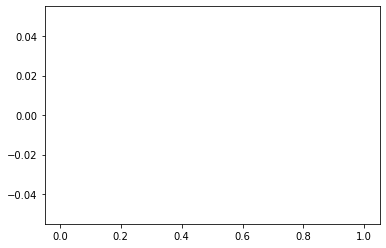

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6a5deefcf8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6a5de7d2e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6a5deefa90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6a5de7d898>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6a5de7db70>],
 'means': []}

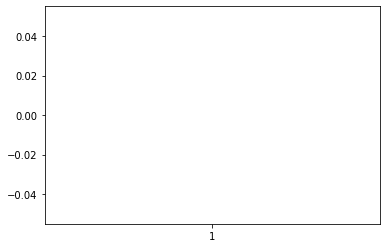

In [91]:
import plotly.graph_objs as go
# Scale the labels
scale = 2

# Create traces for the first dataset
traces = []
traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))
traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))

# Create the layout
layout = go.Layout(
    title='Combined Plot',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Values'),
    showlegend=True
)

# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)
fig.show()
# calculate latency per contact event
detection_delays = []
true_label_index = testing_data.label[testing_data.label.diff()>0.8].index
no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.8].index

true_positive= np.zeros_like(true_label_index)
counter = 0
for i , end_i in zip(true_label_index, no_contact_start_index):
    state = False
    for j in range(end_i-i): 
        #if testing_data.model_out[i+j]:
        if (i+j) in predicted_label_index:
            detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
            true_positive[counter]=1
            counter = counter +1
            state=True
            break
    if not state:
        true_positive[counter]=0
        counter = counter +1


print('Single contact analysis')
print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
print(f'Effective Detection delay (less than 250 ms): {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
%matplotlib inline
plt.hist(detection_delays, bins=20)
plt.show()
plt.boxplot(detection_delays)

In [ ]:
%matplotlib inline
plt.plot(testing_data.model_out)

In [ ]:
true_label_csv = pd.read_csv('/home/rzma/myProjects/contactInterpretation/urRobot/DATA/model_out/t1/true_label.csv')
time_model = true_label_csv.time_sec + true_label_csv.time_nsec
time_model = time_model - time_model[0]
(time_model.diff()>0.1).sum()


In [ ]:
%matplotlib inline
plt.plot(time_model, time_model.diff())

In [ ]:
model_out_csv = pd.read_csv('/home/rzma/myProjects/contactInterpretation/urRobot/DATA/model_out/12/model_out.csv')
(model_out_csv.contact_out.diff()>0.3).sum()

In [ ]:
time = model_out_csv.Time_nsec+model_out_csv.Time_sec
time = time -time[0]
plt.plot( model_out_csv.contact_out)